In [1]:
# The notebook's environment might not recognise local installs of ADRpy, fix that now...
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))

<img src="../img/ADRpy_splash.png" width="30%" align="left">

*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving 'scale' to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the aeroplane we progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*Based on the example in* "Small Unmanned Fixed-wing Aircraft Design: A Practical Approach" *by Keane, Sobester and Scanlan.*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as uc
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

# Constraint Analysis of a Small Fixed-wing UAV

First, we set up a dictionary variable containing elements of the design brief. All of the requirements below refer to ISA standard day conditions (see the documentation for the ``Atmosphere`` class for how to instantiate other atmospheres). The dictionary entry ``cruisethrustfact`` defines the throttle setting expected to be used in cruise (1 = full throttle).

In [3]:
designbrief = {
    'rwyelevation_m':0, 'groundrun_m':60,                                   # <- Take-off requirements
    'stloadfactor': 1.41, 'turnalt_m': 0, 'turnspeed_ktas': 40,             # <- Turn requirements
    'climbalt_m': 0, 'climbspeed_kias': 46.4, 'climbrate_fpm': 591,         # <- Climb requirements
    'cruisealt_m': 122, 'cruisespeed_ktas': 58.3, 'cruisethrustfact': 1.0,  # <- Cruise requirements
    'servceil_m': 152, 'secclimbspd_kias': 40,                              # <- Service ceiling requirements
    'vstallclean_kcas': 26.4                                                # <- Required clean stall speed
}

Initial estimate of the take-off weight:

In [4]:
TOW_kg = 15.0

Some constraints may not have to be satisfied at MTOW - ``wfract`` specifies the weight fraction corresponding to each constraint:

In [5]:
wfract = {'turn': 1.0, 'climb': 1.0, 'cruise': 1.0, 'servceil': 1.0}

These fractions, as well as some basic design parameters are specified in the ``designdefinition`` dictionary: aspect ratio, leading edge sweep, and sweep of the maximum thickness line of the wing.

In [6]:
designdefinition = {
    'aspectratio':9.0, 'sweep_le_deg':2, 'sweep_mt_deg':0,  # <- Wing geometry
    'weightfractions':wfract, "weight_n": uc.kg_N(TOW_kg)   # <- Weight definitions
} 

We next define some design performance estimates, e.g., the propeller efficiencies ($\eta_\mathrm{prop}$) corresponding to the various constraints, drag and lift coefficients and the wheel rolling resistance coefficient:

In [7]:
etas = {k: 0.6 for k in ["take-off", "climb", "cruise", "turn", "servceil"]}

designperformance = {
    'CLTO':0.97, 'CLmaxTO':1.7, 'mu_R':0.17,        # Take-off specific performance
    'CLmax': 1.0, 'CDmin':0.0418, 'eta_prop': etas  # General performance
}

Define the atmosphere in which the calculations are to be conducted - in this case the International Standard Atmosphere. Other atmospheres available in the ``Atmospheres`` class: off-standard ISAs, MIL-HDBK-310 and bespoke atmospheres.

In [8]:
designatm = at.Atmosphere()

We are now ready to instantiate the aircraft concept object, with a propulsion type specifier for generic piston engine aircraft:

In [9]:
concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm, "Piston")

We define a range of wing loadings for which we want to compute the required power:

In [10]:
wingloadinglist_pa = np.arange(25, 2500, 2.5)

And the main event: we call the power calculation methods, as well as the method for calculating the minimum area dictated by the stall requirement:

In [11]:
# Compute thrust/power to weight
twreq_climb, pwreq_climb = concept.constrain_climb(wingloadinglist_pa)
twreq_cruise, pwreq_cruise = concept.constrain_cruise(wingloadinglist_pa)
twreq_servceil, pwreq_servceil = concept.constrain_servceil(wingloadinglist_pa)
twreq_takeoff, pwreq_takeoff = concept.constrain_takeoff(wingloadinglist_pa)
twreq_turn, pwreq_turn = concept.constrain_turn(wingloadinglist_pa)

preq = {
    "climb": uc.W_hp(pwreq_climb * concept.design.weight_n),
    "cruise": uc.W_hp(pwreq_cruise * concept.design.weight_n),
    "servceil": uc.W_hp(pwreq_servceil * concept.design.weight_n),
    "take-off": uc.W_hp(pwreq_takeoff * concept.design.weight_n),
    "turn": uc.W_hp(pwreq_turn * concept.design.weight_n)
}

## Power versus wing area

We can now generate a plot of the various constraint curves in the power versus wing area space:

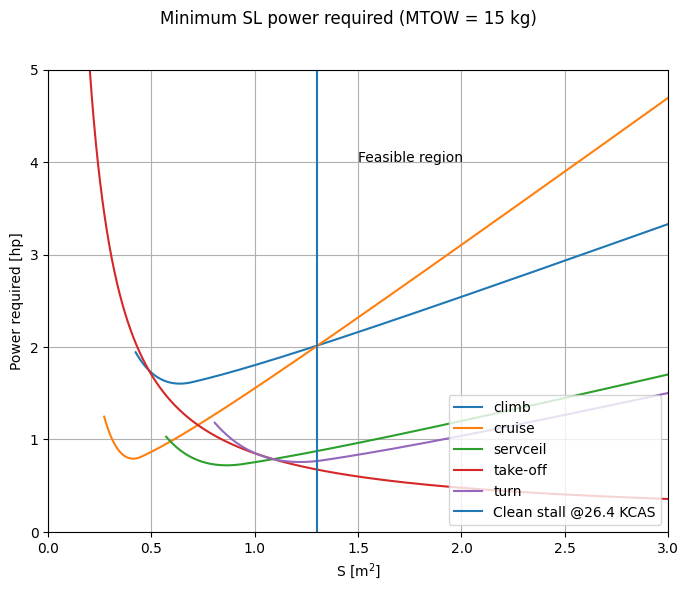

In [12]:
wingarea_m2 = uc.kg_N(TOW_kg) / wingloadinglist_pa # x axis

fig, ax = plt.subplots(figsize=(8, 6))

for (constraintname, constraint_power) in preq.items():
    ax.plot(wingarea_m2, constraint_power, label=constraintname)
stall_label = f"Clean stall @{concept.brief.vstallclean_kcas} KCAS"
ax.axvline(concept.wing_Sref, label=stall_label)

ax.set_ylabel("Power required [hp]")
ax.set_xlabel("S [m$^2$]")
fig.suptitle(f"Minimum SL power required (MTOW = {round(TOW_kg)} kg)")
ax.text(1.5, 4, 'Feasible region')
ax.set_xlim(0, 3)
ax.set_ylim(0, 5)
ax.legend(loc="lower right")
ax.grid()

plt.show()

## T/W versus wing loading

In [13]:
twreq = {
    "climb": twreq_climb,
    "cruise": twreq_cruise,
    "servceil": twreq_servceil,
    "take-off": twreq_takeoff,
    "turn": twreq_turn
}

In [14]:
# Calculate the max wing loading, as driven by the clmax in the approach configuration
# (use the ADRpy method for the clean stall W/S requirement and scale it with approach Clmax)

clmaxapproach = 1.3
WSmax_clean_stall = concept.wing_Sref
WSmax_approach_stall = WSmax_clean_stall / concept.performance.CLmax * clmaxapproach
print(WSmax_approach_stall)

1.6926396062729525


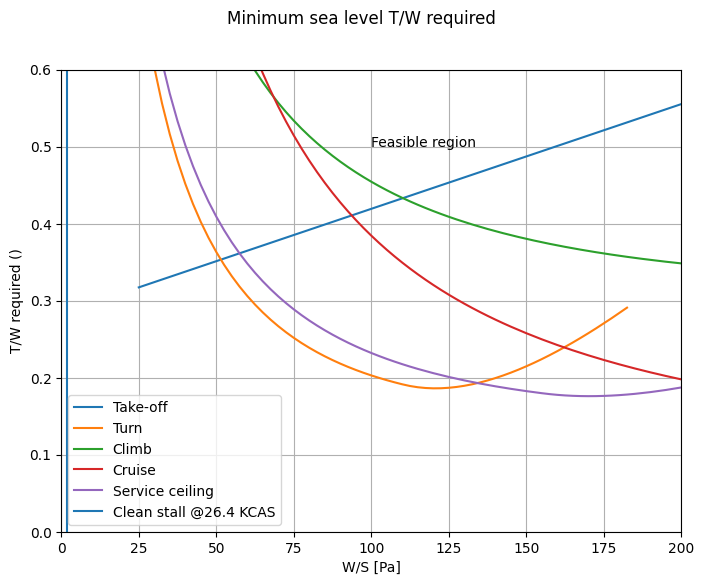

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(wingloadinglist_pa, twreq['take-off'], label = 'Take-off')
ax.plot(wingloadinglist_pa, twreq['turn'], label = 'Turn')
ax.plot(wingloadinglist_pa, twreq['climb'], label = 'Climb')
ax.plot(wingloadinglist_pa, twreq['cruise'], label = 'Cruise')
ax.plot(wingloadinglist_pa, twreq['servceil'], label = 'Service ceiling')
ax.axvline(WSmax_approach_stall, label = stall_label)

fig.suptitle("Minimum sea level T/W required")
ax.text(100, 0.5, 'Feasible region')
ax.set_xlabel("W/S [Pa]")
ax.set_ylabel("T/W required ()")
ax.set_xlim(0, 200)
ax.set_ylim(0, 0.6)
ax.grid()
ax.legend(loc='lower left')

plt.show()

## Power versus wing loading

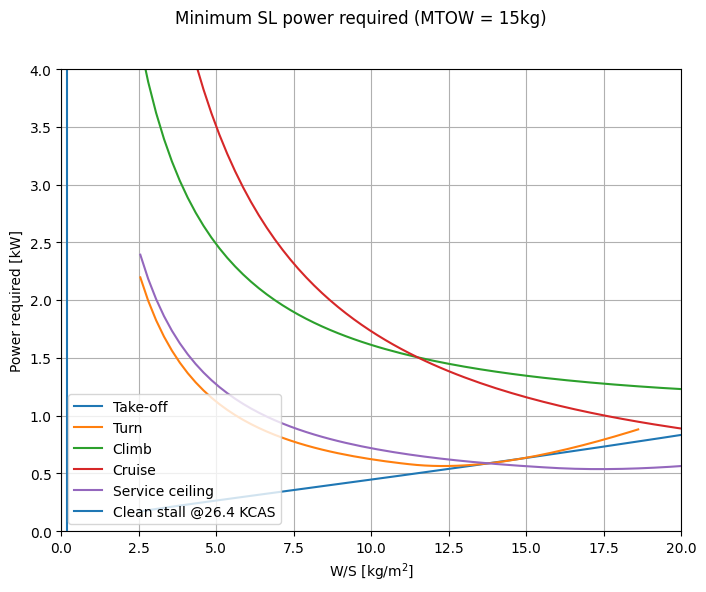

In [16]:
wingloadinglist_kgm2 = uc.Pa_kgm2(wingloadinglist_pa)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(wingloadinglist_kgm2, uc.hp_kW(preq['take-off']), label = 'Take-off')
ax.plot(wingloadinglist_kgm2, uc.hp_kW(preq['turn']), label = 'Turn')
ax.plot(wingloadinglist_kgm2, uc.hp_kW(preq['climb']), label = 'Climb')
ax.plot(wingloadinglist_kgm2, uc.hp_kW(preq['cruise']), label = 'Cruise')
ax.plot(wingloadinglist_kgm2, uc.hp_kW(preq['servceil']), label = 'Service ceiling')
ax.axvline(uc.Pa_kgm2(WSmax_approach_stall), label = stall_label)

fig.suptitle("Minimum SL power required (MTOW = " + str(round(TOW_kg)) + "kg)")
ax.set_xlabel("W/S [kg/m$^2$]")
ax.set_ylabel("Power required [kW]")
ax.set_xlim(0, 20)
ax.set_ylim(0, 4)
ax.grid()
ax.legend(loc='lower left')

plt.show()